# Tutorial 1

In [1]:
#https://realpython.com/python-nltk-sentiment-analysis/


In [72]:
import numpy as np

In [2]:
import nltk
from pprint import pprint

In [3]:
words = [w for w in nltk.corpus.state_union.words() if w.isalpha()]

In [4]:
stopwords = nltk.corpus.stopwords.words("english")

In [5]:
words =[w for w in words if w.lower() not in stopwords]

In [6]:
fd = nltk.FreqDist(words)

In [7]:
fd.most_common(3)

[('must', 1568), ('people', 1291), ('world', 1128)]

In [8]:
fd.tabulate(3)

  must people  world 
  1568   1291   1128 


In [9]:
text = nltk.Text(nltk.corpus.state_union.words())
text.concordance("america", lines=5)

Displaying 5 of 1079 matches:
 would want us to do . That is what America will do . So much blood has already
ay , the entire world is looking to America for enlightened leadership to peace
beyond any shadow of a doubt , that America will continue the fight for freedom
 to make complete victory certain , America will never become a party to any pl
nly in law and in justice . Here in America , we have labored long and hard to 


In [10]:
words = [w for w in nltk.corpus.state_union.words() if w.isalpha()]
finder = nltk.collocations.TrigramCollocationFinder.from_words(words)

In [11]:
finder.ngram_fd.most_common(2)
finder.ngram_fd.tabulate(2)

  ('the', 'United', 'States') ('the', 'American', 'people') 
                          294                           185 


In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is reall powerful!")
sia.polarity_scores("today was great!")

{'neg': 0.0, 'neu': 0.313, 'pos': 0.687, 'compound': 0.6588}

In [13]:
tweets = [t.replace("://", "//") for t in nltk.corpus.twitter_samples.strings()]

In [14]:
from random import shuffle

def is_positive(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia.polarity_scores(tweet)["compound"] > 0

shuffle(tweets)
for tweet in tweets[:10]:
    print(">", is_positive(tweet),'::::SPACER::::', tweet)

> False ::::SPACER:::: @BOYBANDSFTCARA sure!!! Sorry :( x
> False ::::SPACER:::: RT @HolyToryLane: The movie is here: http//t.co/OO7JJEVyuF
Tory Lane... http//t.co/92Q5eqNCGy
> False ::::SPACER:::: AND HELLO TWITTER, MY ACCOUNT IS BROKEN AGAIN :)
> False ::::SPACER:::: So @UKIP believe it's our governments fault that Putin annexed Ukraine #OffYourRocker #AskNigelFarage
> False ::::SPACER:::: RT @Rad1o_Head: Members of @scottishlabour - feeling unloved by one of your own? Do what I did and join the SNP. It's never too late. :) #G…
> False ::::SPACER:::: RT @NPickavance: FT backs Tories! Who'd have guessed that FT leader writer Jonathan Ford was photod posing nxt to Boris in Uni club? http:/…
> True ::::SPACER:::: RT @UKLabour: RETWEET: Our new election poster. The Tories will cut child benefit, tonight confirmed it. #bbcqt http//t.co/RAtRrr8xjY
> False ::::SPACER:::: RT @HumzaYousaf: That sound you hear is the final nail hammered into New Labour coffin as Ed Miliband says he'd rather le

In [15]:
positive_review_ids = nltk.corpus.movie_reviews.fileids(categories=["pos"])
negative_review_ids = nltk.corpus.movie_reviews.fileids(categories=["neg"])
all_review_ids = positive_review_ids + negative_review_ids

In [16]:
from statistics import mean
def is_positive(review_id: str) -> bool:
    """True if the average of all sentance compound scores is positive."""
    text = nltk.corpus.movie_reviews.raw(review_id)
    scores = [
        sia.polarity_scores(sentance)["compound"]
        for sentance in nltk.sent_tokenize(text)
    ]
    return mean(scores) > 0

In [17]:
shuffle(all_review_ids)
correct = 0
for review_id in all_review_ids:
    if is_positive(review_id):
        if review_id in positive_review_ids:
            correct += 1
    else: 
        if review_id in negative_review_ids:
            correct += 1

print(F"{correct / len(all_review_ids):.2%} correct")

64.00% correct


In [18]:
unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend([w.lower() for w in nltk.corpus.names.words()])

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    if tag.startswith("NN"):
        return False
    return True

positive_words = [word for word, tag in filter(
    skip_unwanted,
    nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=['pos']))
)]
negative_words = [word for word, tag in filter(
    skip_unwanted,
    nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=["neg"]))
                )]

In [19]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del  positive_fd[word]
    del negative_fd[word]
    
top_100_positive = {word for word, count in positive_fd.most_common(100)}
top_100_negative = {word for word, count in negative_fd.most_common(100)}

In [20]:
unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend([w.lower() for w in nltk.corpus.names.words()])

postiive_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(
w for w in nltk.corpus.movie_reviews.words(categories=["pos"])
if w.isalpha() and w not in unwanted
    )

negative_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(
    w for w in nltk.corpus.movie_reviews.words(categories=["neg"])
    if w.isalpha() and w not in unwanted
    )

# Training and using a Classifier

In [22]:
def extract_features(text):
    features = dict()
    wordcount = 0
    compound_scores = list()
    positive_scores = list()
    
    for sentance in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentance):
            if word.lower() in top_100_positive:
                wordcount += 1
        compound_scores.append(sia.polarity_scores(sentance)["compound"])
        positive_scores.append(sia.polarity_scores(sentance)["pos"])
        
    # Adding 1 to the final compound score to always have positive numbers
    # since some classifiers used later don't work with negative numbers.
    
    features["mean_compound"] = mean(compound_scores) + 1
    features["mean_positive"] = mean(positive_scores)
    features["wordcount"] = wordcount
    
    return features

In [23]:
features = [
    (extract_features(nltk.corpus.movie_reviews.raw(review)), "pos")
    for review in nltk.corpus.movie_reviews.fileids(categories=["pos"])
]
features.extend([
    (extract_features(nltk.corpus.movie_reviews.raw(review)), "neg")
    for review in nltk.corpus.movie_reviews.fileids(categories=["neg"])
])

In [24]:
train_count = len(features) // 4
shuffle(features)
classifier = nltk.NaiveBayesClassifier.train(features[:train_count])
classifier.show_most_informative_features(10)

Most Informative Features
               wordcount = 2                 pos : neg    =      3.2 : 1.0
               wordcount = 1                 pos : neg    =      1.9 : 1.0
               wordcount = 4                 pos : neg    =      1.8 : 1.0
               wordcount = 0                 neg : pos    =      1.8 : 1.0
           mean_positive = 0.09305263157894737    neg : pos    =      1.0 : 1.0


In [25]:
nltk.classify.accuracy(classifier, features[train_count:])

0.6473333333333333

# Other Classifiers

# Sklearn

In [26]:
from sklearn.naive_bayes import (BernoulliNB, ComplementNB, MultinomialNB,)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [27]:
classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

In [28]:
features = [
    (extract_features(nltk.corpus.movie_reviews.raw(review)), "pos")
    for review in nltk.corpus.movie_reviews.fileids(categories=["pos"])
]
features.extend([
    (extract_features(nltk.corpus.movie_reviews.raw(review)), "neg")
    for review in nltk.corpus.movie_reviews.fileids(categories=["neg"])
])

In [29]:
train_count = len(features) // 4
shuffle(features)
for name, sklearn_classifier in classifiers.items():
    classifier = nltk.classify.SklearnClassifier(sklearn_classifier)
    classifier.train(features[:train_count])
    accuracy = nltk.classify.accuracy(classifier, features[train_count:])
    print(F"{accuracy:.2%} - {name}")

66.27% - BernoulliNB
65.67% - ComplementNB
65.00% - MultinomialNB
69.93% - KNeighborsClassifier
64.07% - DecisionTreeClassifier
69.07% - RandomForestClassifier
71.20% - LogisticRegression
72.87% - MLPClassifier
69.93% - AdaBoostClassifier


## Tutorial 2

In [30]:
#https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair

In [31]:
from textblob import TextBlob

## Subject-objectivity measure?!?

In [32]:
testimonial = TextBlob("The food was great!")
print(testimonial.sentiment)

Sentiment(polarity=1.0, subjectivity=0.75)


In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentence = "The Food was great!"
vs = analyzer.polarity_scores(sentence)
print("{:-<65} {}".format(sentence, str(vs)))

The Food was great!---------------------------------------------- {'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}


In [ ]:
#from flair.models import TextClassifier
#from flair.data import Sentence

#classifier = TextClassifier.load('en-sentiment')
#sentence = Sentence('The food was great!')
#classifier.predict(senetence)

#print('Sentence above is ', sentence.labels)

## Tutorial 3 

In [35]:
#https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

In [36]:
import pandas as pd
df = pd.read_csv('Reviews.csv')
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

# Product Scores

fig = px.histogram(df, x="Score")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Score')
fig.show()

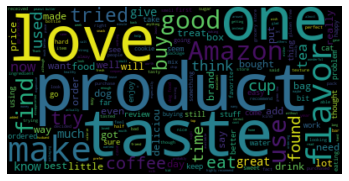

In [50]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [87]:
# assign reviews with score > 3 as positive sentiment
# score < 3 negative sentiment
# remove score = 3
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else -1)

In [88]:
# split df - positive and negative sentiment:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

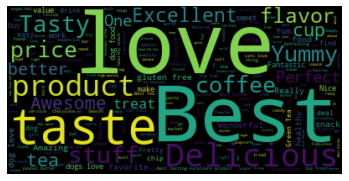

In [89]:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href","good","great"]) 
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.Summary)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [90]:
negative.Summary = negative.Summary.astype(str)

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



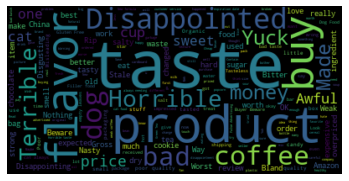

In [91]:
neg = " ".join(review for review in negative.Summary)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

In [92]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df['Text'] = df['Text'].apply(remove_punctuation)
df = df.dropna(subset=['Summary'])
df['Summary'] = df['Summary'].apply(remove_punctuation)

In [93]:
dfNew = df[['Summary','sentiment']]
dfNew.head()

Summary  sentiment
0  Good Quality Dog Food          1
1      Not as Advertised         -1
2    Delight says it all          1
3         Cough Medicine         -1
4            Great taffy          1

In [94]:
# random split train and test data # we know to use an sklearn library for cleaner operation
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [95]:
# count vectorizer:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Summary'])
test_matrix = vectorizer.transform(test['Summary'])

In [96]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [97]:
y_train.value_counts()

1           349829
negative     64597
Name: sentiment, dtype: int64

In [98]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [99]:
lr.fit(X_train,y_train)

c:\users\prathmun\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [100]:
predictions = lr.predict(X_test)

In [101]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[11476,  2351],
       [ 5888, 91538]], dtype=int64)

In [102]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.66      0.83      0.74     13827
           1       0.97      0.94      0.96     97426

    accuracy                           0.93    111253
   macro avg       0.82      0.88      0.85    111253
weighted avg       0.94      0.93      0.93    111253

